In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.TwoDoF as TwoDoF
from FwtModels import GetAoA

from matplotlib.lines import Line2D

me.mechanics_printing()

In [126]:
half = sym.Rational(1,2)
fwt_panels = 10

def defualt_params():

    p = mf.ModelParameters.DynamicModel(1)
    p.c = mf.ModelSymbol(value = 0.15,string = 'c') # chord of wing
    p.m = mf.ModelSymbol(value = 1,string = 'm')      # mass of fwt
    p.s = mf.ModelSymbol(value = 1,string = 's')      # span of fwt
    p.I_xx = mf.ModelSymbol(value = 1,string = 'I_xx')

    p.l_com = mf.ModelSymbol(value = 0.5,string='l_com') # distance from Hinge to CoM
    p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # flare angle

    p.rho = mf.ModelSymbol(value = 1.225,string = 'rho')                 # Density
    p.V = mf.ModelSymbol(value = 10,string = 'V')                        # Velocity
    p.g  = mf.ModelSymbol(value = 9.81,string = 'g')                     # Gravity
    p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # Root AoA
    p.alpha_c = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_c') # Root AoA
    p.beta = mf.ModelSymbol(value = np.deg2rad(3),string = 'beta') # Beta

    p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
    p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

    ## FWTD Structural Parameters
    p.y_0 = sym.Symbol('y_0')
    p.y_i = sym.Symbol('y_i')
    p.x_0 = sym.Symbol('x_0')

    ## Numeric Model Constants
    p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point
    p.a = mf.ModelMatrix(value =[np.pi*2]*fwt_panels,symbols=sym.symbols(f'a:{fwt_panels}')) # The aero derivative on each panel

    ## FWT C_L 
    p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0')   # C_L at the root
    return p


p = defualt_params()


In [127]:
#Define refernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r).R_x(p.q[0])

# Define Elements
M_Wingtip = ele.RigidElement.PointMass(wing_root_frame.Translate(0,p.l_com,0),p.m,True)

# Define Aero Forces
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_root_frame.Translate(0,p.y_i,0),p.a_0,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               w_g = 0,
                               rootAlpha = p.alpha_1+p.alpha_c,
                               alpha_zero = 0,
                               stall_angle = 0,
                               c = p.c,
                               c_d_max = 0,
                                V = sym.cos(p.beta)*p.V,
                               linear = True)

# split Main Wing into segments
forces = []
for i in range(fwt_panels):
    seg_width = p.s/fwt_panels
    yi = seg_width/2 + i*seg_width
    forces.append(wing_AeroForces.subs({p.y_i:yi,p.a_0:p.a[i]})*seg_width)

Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
wing_AeroForces = ef.ExternalForce(Q)

# create instance of the model
sm = mf.SymbolicModel.FromElementsAndForces(p,[M_Wingtip],ExtForces = wing_AeroForces)

#
aoa = GetAoA(p.alpha_r,p.beta,p.Lambda,p.q[0])
sm = sm.msubs({p.alpha_1:-aoa})
# sm = sm.msubs({p.alpha_1:-sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[0]))})
sm.to_file('tempModel_free.py')


In [236]:
import itertools
# create lift distribution
def create_lift_dist_from_file(filename,span,panels):

    delta = span / panels
    y_panel = np.linspace(delta/2,span-delta/2,panels)
    y_panel = [y+1 for y in y_panel]

    ## load lift distribution
    df = pd.read_csv(filename)
    y_span = df['y'].to_numpy()
    y_c_l = df['C_l'].to_numpy()

    # interpolate on each panel
    return list(np.interp(np.abs(y_panel),y_span,y_c_l,left=0,right=0))

def Model_run(Lambda,beta,V,alpha_r,theta,alpha_c,g,fwt_panels = 10):   
    dataset_name = 'Test'
    # Set JEC Specific parameters
    sm = mf.SymbolicModel.from_file('tempModel_free.py')
    p = defualt_params()
    p.rho.value = 1.225
    p.s.value = 0.325
    p.c.value = 0.15
    p.m.value = 0.45
    p.a.value = create_lift_dist_from_file('LiftDistribution_aoa_5_span_265.csv',0.325,fwt_panels)
    p.l_com.value = 0.2059
    nm = mf.NumericModel.from_SymbolicModel(p,sm)
    
    cases = itertools.product(Lambda,beta,V,alpha_r,theta,alpha_c,g)
    
    def set_values(p,nm,Lambda,beta,V,alpha_r,theta,alpha_c,g):
        p.Lambda.value = np.deg2rad(Lambda)
        p.V.value = V
        p.alpha_r.value = np.deg2rad(alpha_r)
        p.beta.value = np.deg2rad(beta)
        p.alpha_c.value = np.deg2rad(alpha_c)
        p.g.value = g
        x = [np.deg2rad(theta),0]    
        t = 0
        tup = p.GetNumericTuple(x,t)
        if V==0:
            return (Lambda,beta,V,alpha_r,theta,alpha_c,g,-nm.f_func(tup,x)[0][0],0)
        else:
            return (Lambda,beta,V,alpha_r,theta,alpha_c,g,-nm.f_func(tup,x)[0][0],nm.ExtForces(tup,x,t)[0,0])
    return map(lambda x:set_values(p,nm,*x),cases)

In [313]:
L = [10]
T = np.linspace(-120,120,121)
B = np.linspace(-10,10,9)
A = np.linspace(-10,10,9)
V = np.linspace(10,50,9)
C = np.append(np.linspace(-6,6,7),12)
G = np.linspace(0,9.81,2)
res = list(Model_run(L,B,V,A,T,C,G))



In [314]:
res = pd.DataFrame(res,columns=['Lambda','Beta','V','Root Alpha','Theta','Alpha_c','g','f','Q'])
# res['Lambda'] = res['Lambda'].apply(np.rad2deg)
# res['Beta'] = res['Beta'].apply(np.rad2deg)
# res['Root Alpha'] = res['Root Alpha'].apply(np.rad2deg)
# res['Theta'] = res['Theta'].apply(np.rad2deg)


Text(0, 0.5, 'Moment about the Hinge [N]')

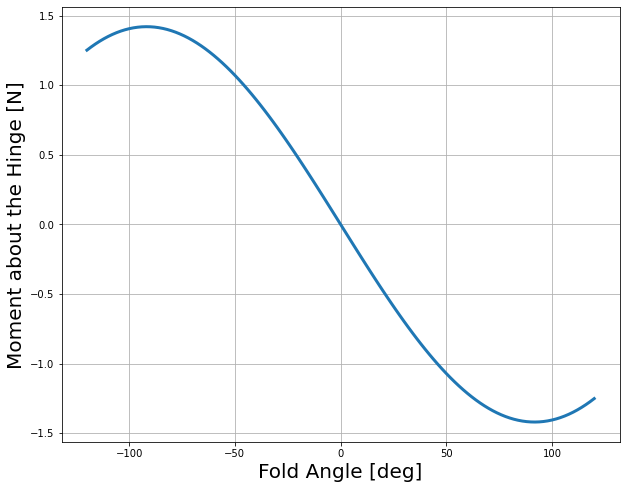

In [317]:
b = 0
ra = 0
fig = plt.figure(figsize=(10,8))
tmp_res = res[(res['Root Alpha']==ra) & (res['Beta']==0) & (res['V']==20) & (res['Alpha_c']==0) & (res['g']==0)]
#     plt.plot(tmp_res['Theta'],(tmp_res['f']),label='Gravitational Moment',color=[0,0,1])
#     if bs[i] == 0:
#         c = [1,0,0]
#     else:
#         c = [shades[i],shades[i],1]
p = plt.plot(tmp_res['Theta'],(tmp_res['Q']),linewidth=3)
#     plt.plot(tmp_res['Theta'],(tmp_res['f']+tmp_res['Q']),label='Combined Moment')
plt.grid()
plt.xlabel('Fold Angle [deg]',fontsize=20)
plt.ylabel('Moment about the Hinge [N]',fontsize=20)

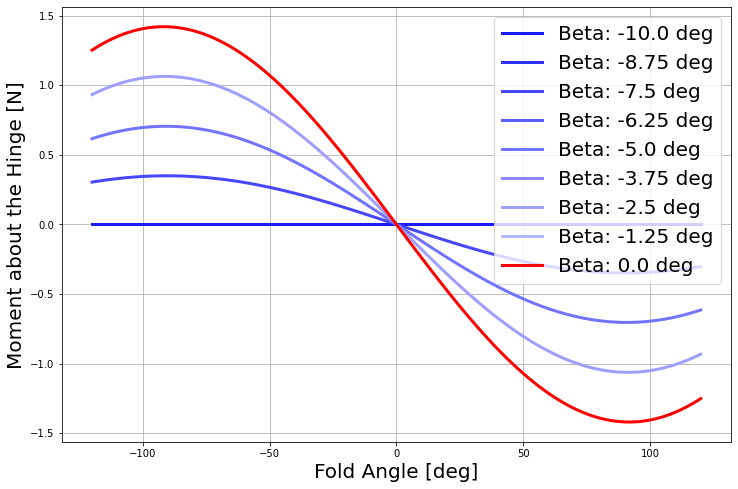

In [320]:
b = 0
ra = 0
bs = np.linspace(-10,10,9)
shades = np.linspace(0.1,0.8,len(bs))
fig = plt.figure(figsize=(12,8))
for i in range(len(bs)):
    tmp_res = res[(res['Root Alpha']==ra) & (res['Beta']==bs[i]) & (res['V']==20) & (res['Alpha_c']==0) & (res['g']==0)]
#     plt.plot(tmp_res['Theta'],(tmp_res['f']),label='Gravitational Moment',color=[0,0,1])
    if bs[i] == 0:
        c = [1,0,0]
    else:
        c = [shades[i],shades[i],1]
    p = plt.plot(tmp_res['Theta'],(tmp_res['Q']),label=f'Beta: {bs[i]} deg',color=c,linewidth=3)
#     plt.plot(tmp_res['Theta'],(tmp_res['f']+tmp_res['Q']),label='Combined Moment')
plt.grid()
plt.xlabel('Fold Angle [deg]',fontsize=20)
plt.ylabel('Moment about the Hinge [N]',fontsize=20)
plt.legend(fontsize=20)

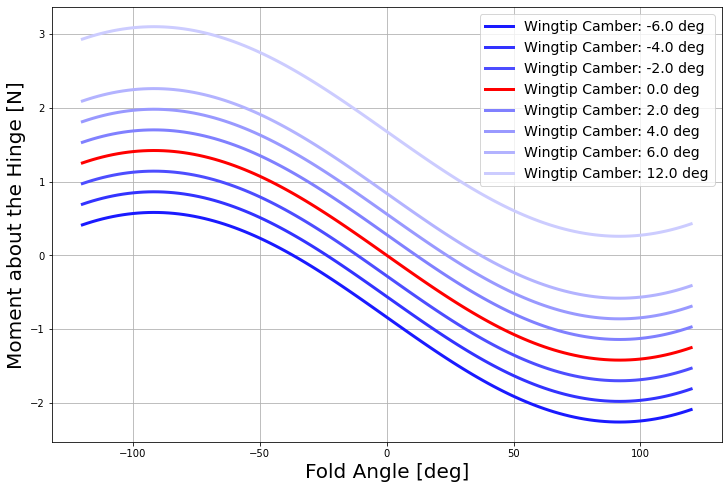

In [319]:
b = 0
ra = 0
acs = np.append(np.linspace(-6,6,7),12)
shades = np.linspace(0.1,0.8,len(acs))
fig = plt.figure(figsize=(12,8))
for i in range(len(acs)):
    tmp_res = res[(res['Root Alpha']==ra) & (res['Beta']==0) & (res['V']==20) & (res['Alpha_c']==acs[i]) & (res['g']==0)]
#     plt.plot(tmp_res['Theta'],(tmp_res['f']),label='Gravitational Moment',color=[0,0,1])
    if acs[i] == 0:
        c = [1,0,0]
    else:
        c = [shades[i],shades[i],1]
    p = plt.plot(tmp_res['Theta'],(tmp_res['Q']),label=f'Wingtip Camber: {acs[i]} deg',color=c,linewidth=3)
#     plt.plot(tmp_res['Theta'],(tmp_res['f']+tmp_res['Q']),label='Combined Moment')
plt.grid()
plt.xlabel('Fold Angle [deg]',fontsize=20)
plt.ylabel('Moment about the Hinge [N]',fontsize=20)
plt.legend(fontsize=14)

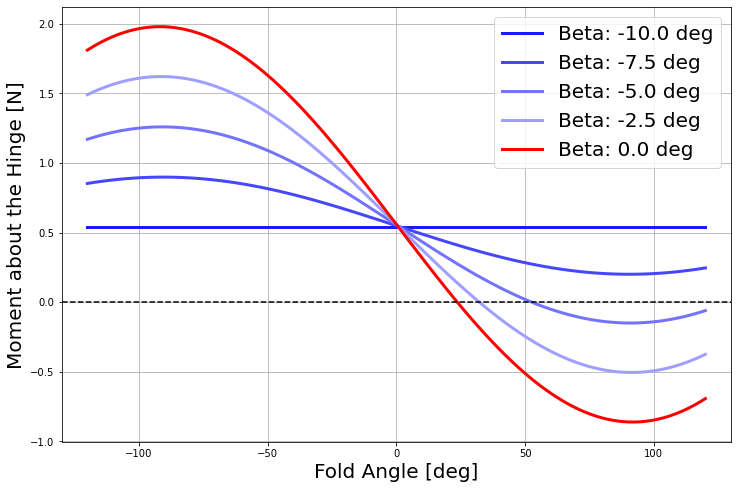

In [329]:
b = 0
ra = 0
bs = np.linspace(-10,0,5)
shades = np.linspace(0.1,0.8,len(bs))
fig = plt.figure(figsize=(12,8))
for i in range(len(bs)):
    tmp_res = res[(res['Root Alpha']==ra) & (res['Beta']==bs[i]) & (res['V']==20) & (res['Alpha_c']==4) & (res['g']==0)]
#     plt.plot(tmp_res['Theta'],(tmp_res['f']),label='Gravitational Moment',color=[0,0,1])
    if bs[i] == 0:
        c = [1,0,0]
    else:
        c = [shades[i],shades[i],1]
    p = plt.plot(tmp_res['Theta'],(tmp_res['Q']),label=f'Beta: {bs[i]} deg',color=c,linewidth=3)
#     plt.plot(tmp_res['Theta'],(tmp_res['f']+tmp_res['Q']),label='Combined Moment')
plt.grid()
plt.xlabel('Fold Angle [deg]',fontsize=20)
plt.ylabel('Moment about the Hinge [N]',fontsize=20)
plt.plot([-130,130],[0,0],'k--')
plt.xlim([-130,130])
plt.legend(fontsize=20)

<AxesSubplot:xlabel='Theta', ylabel='Q'>

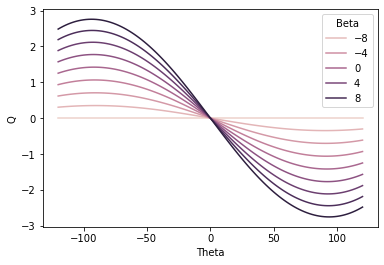

In [268]:

tmp_res = res[(res['Root Alpha']==ra) & (res['V']==20) & (res['Alpha_c']==0) & (res['g']==0)]

sns.lineplot(data=tmp_res,x='Theta',y='Q',hue='Beta')

In [ ]:
list(map(lambda x: x[6]+x[7],Model_run([10],[0],[5],[0],[0,-80,-90],[0])))

In [366]:
from scipy.optimize import minimize
def coast_angle(Lambda,beta,V,alpha_r,theta,alpha_c,fwt_panels=10):
    f = lambda x: list(map(lambda x: x[6]+x[7],Model_run([Lambda],[beta],[V],[alpha_r],[x],[alpha_c],[0])))[0]
    return minimize(lambda x: f(x)**2,[-90],bounds=[(-90,150)],method='Nelder-Mead')

coast_angle(10,8,21,0,0,5)

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:517: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


 final_simplex: (array([[-90.        ],
       [-90.00006866]]), array([0., 0.]))
           fun: 0.0
       message: 'Optimization terminated successfully.'
          nfev: 50
           nit: 17
        status: 0
       success: True
             x: array([-90.])

In [98]:
A

array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.])

In [312]:
np.append(np.linspace(0,5,6),[6])

array([0., 1., 2., 3., 4., 5., 6.])

In [436]:
def crit_beta(V,camber):
    f = lambda x: list(map(lambda x: x[-2]+x[-1],Model_run([10],[x],[V],[0],[90],[camber],[20])))[0]
    return minimize(lambda x: f(x)**2,[0])
    

In [437]:
crit_beta(20,8)

      fun: 5.5007450860010853e-14
 hess_inv: array([[24.84047493]])
      jac: array([6.67824696e-08])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-2.11999797])

In [438]:
Vs = np.linspace(2,30,15)
Cs = np.linspace(0,8,9)
cases = itertools.product(Vs,Cs)
mapping = list(map(lambda x: crit_beta(x[0],x[1]),cases))


In [439]:
z = map(lambda x: x.x[0],mapping)
z = list(z)

In [440]:
cases = list(itertools.product(Vs,Cs))
np.reshape([1,2,3,4,5,6],(2,3))

array([[1, 2, 3],
       [4, 5, 6]])

Text(0, 0.5, 'Velocity [m/s]')

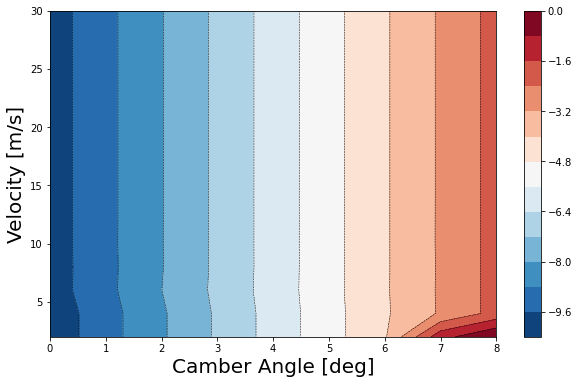

In [441]:
z = np.reshape(z,(len(Vs),len(Cs)))

plt.figure(figsize=(10,6))
plt.contour(Cs,Vs,z, levels=14, linewidths=0.5, colors='k')
cntr1 = plt.contourf(Cs,Vs,z, levels=14, cmap="RdBu_r")
plt.colorbar(cntr1)
plt.xlabel('Camber Angle [deg]',fontsize=20)
plt.ylabel('Velocity [m/s]',fontsize=20)
# fig.plot(x, y, 'ko', ms=3)
# ax1.set(xlim=(-2, 2), ylim=(-2, 2))
# ax1.set_title('grid and contour (%d points, %d grid points)' %
#               (npts, ngridx * ngridy))